In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import nltk
import os
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import string
import re
from collections import Counter


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hladn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hladn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hladn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
cwd = os.getcwd()
df = pd.read_csv( os.path.join(cwd, 'full_dataset_all_labels.csv'))
stop_words=set(stopwords.words('english') + list(string.punctuation))
stop_words.add('rt') # add word rt (meaning retweet) to stop words
df = pd.read_csv('full_dataset_all_labels.csv')


In [10]:
i=21750
print(df['text'].iloc[i])
#print(df['tokenized_text'].iloc[i])
df[df['text'].str.contains("<USER> that's not how it works")]

RETARD 

I'ts my flippen opinion anyways and how about get a life intead of reporting peoplego get laid you stupid gay virgin


,text,label
77205,<USER> that's not how it works bitch <URL>,vulgar


In [11]:
def print_some_texts(columns, df):
    text_idxs = [47, 7240, 7241, 8013, 14500, 16500, 16304, 18300,  21750, 34036, 45159, 71920]
    for i in text_idxs:
        for column in columns:
            print(df[column].iloc[i])
#print_some_texts(['text'])

def tokenize(text):
    #print(text)
    text = preprocess_text(text)
    #print(text)
    tokens = word_tokenize(text)
    filtered_tokens = []
    # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation). (adapted from lab example)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            if token not in stop_words and len(token) > 2:
                filtered_tokens.append(token)
    return filtered_tokens
    

def preprocess_text(text):
    text = re.sub(r"http\S+", " ", text)            # remove urls
    text = re.sub("@[A-Za-z0-9]+","", text)         # remove twitter handle
    text = re.sub("&amp;","", text)                  # &amp; is a special character for ampersand
    text = re.sub('<USER>', '', text)               # remove '<USER>' as there are some such strings as user or url is masked with this string
    text = re.sub('<URL>', '', text)
    text = text.lower() 
    text = re.sub('[^a-zA-Z]', ' ', text)           # Remove punctuations
    text = text.lower()                             # Convert to lowercase
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)#remove tags
    text = re.sub("(\\d|\\W)+"," ",text)            # remove special characters and digits
    return text
    
    
def stemming(tokens):
    stemmer = SnowballStemmer("english")
    stems = [stemmer.stem(token) for token in tokens]
    return stems

def lemmatizing(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmas

In [12]:
df['preprocessed_text']=df['text'].apply(preprocess_text)
df['tokenized_text']= df['preprocessed_text'].apply(tokenize) 

df['stems']= df['tokenized_text'].apply(stemming) 
df['lemmas']= df['tokenized_text'].apply(lemmatizing) 

In [14]:
df[(df['lemmas']!=df['tokenized_text']) & (df['lemmas'].str.len() < 4)].sample(10)

,text,label,preprocessed_text,tokenized_text,stems,lemmas
8598,RT @elisabethlehem: #ImSoSick of feminists,harassment,rt imsosick of feminists,"[imsosick, feminists]","[imsosick, feminist]","[imsosick, feminist]"
53000,RT @easy_edd: lifes a bitch,offensive,rt edd lifes a bitch,"[edd, lifes, bitch]","[edd, life, bitch]","[edd, life, bitch]"
2128,mods are killing reddit,abuse,mods are killing reddit,"[mods, killing, reddit]","[mod, kill, reddit]","[mod, killing, reddit]"
27820,I am no sockpuppet. Sorry fuckers!,insult,i am no sockpuppet sorry fuckers,"[sockpuppet, sorry, fuckers]","[sockpuppet, sorri, fucker]","[sockpuppet, sorry, fucker]"
71580,no i don't fuck with no hoes only princess now,vulgar,no i don t fuck with no hoes only princess now,"[fuck, hoes, princess]","[fuck, hoe, princess]","[fuck, hoe, princess]"
28496,"Why don't you kiss my ass, prick.",insult,why don t you kiss my ass prick,"[kiss, ass, prick]","[kiss, ass, prick]","[kiss, as, prick]"
56628,all the bitches love me http://t.co/vDnuFGJ37p,offensive,all the bitches love me,"[bitches, love]","[bitch, love]","[bitch, love]"
56171,Y'all all some hoes,offensive,y all all some hoes,[hoes],[hoe],[hoe]
45719,Heat bitches!!!!!!!!!!!,offensive,heat bitches,"[heat, bitches]","[heat, bitch]","[heat, bitch]"
44907,Deez hoes be actin up..,offensive,deez hoes be actin up,"[deez, hoes, actin]","[deez, hoe, actin]","[deez, hoe, actin]"


### combine multiple labels in one or take only a subset of labels

In [15]:
df_default = df.copy() # save default dataframe

In [16]:
# combine multiple labels, according to clustering results we join labels that are close to each other
join_labels = {('hostile', 'racist', 'sexist'): 'HSR', ('harassment', 'profane', 'hateful'):'HPH', ('vulgar', 'slur', 'cyberbullying', 'offensive'):'VSCO', 
          ('homophobic', 'abuse', 'threat', 'severe_toxic', 'identity_hate'): 'HATSI', ('obscene', 'insult'):'OI'}
encoder = {}
for group in join_labels:
    for label in group:
        encoder[label] = join_labels[group]
encoder
df_joined = df_default.replace({'label':encoder})
df_joined.head()

,text,label,preprocessed_text,tokenized_text,stems,lemmas
0,deleted by r news mods,HATSI,deleted by r news mods,"[deleted, news, mods]","[delet, news, mod]","[deleted, news, mod]"
1,to bad the mods deleted this post nothing to s...,HATSI,to bad the mods deleted this post nothing to s...,"[bad, mods, deleted, post, nothing, see]","[bad, mod, delet, post, noth, see]","[bad, mod, deleted, post, nothing, see]"
2,r news mods hate lgbtq people and downplay the...,HATSI,r news mods hate lgbtq people and downplay the...,"[news, mods, hate, lgbtq, people, downplay, de...","[news, mod, hate, lgbtq, peopl, downplay, death]","[news, mod, hate, lgbtq, people, downplay, death]"
3,kill yourself sincerely r news mods,HATSI,kill yourself sincerely r news mods,"[kill, sincerely, news, mods]","[kill, sincer, news, mod]","[kill, sincerely, news, mod]"
4,discussion is haram and we hate gay people r n...,HATSI,discussion is haram and we hate gay people r n...,"[discussion, haram, hate, gay, people, news, m...","[discuss, haram, hate, gay, peopl, news, mod]","[discussion, haram, hate, gay, people, news, mod]"


In [17]:
# label subset df
labels_subset = ['homophobic', 'racist', 'sexist', 'cyberbullying', 'threat']
df_subset = df_default.loc[df_default['label'].isin(labels_subset)]
df_subset.head()

,text,label,preprocessed_text,tokenized_text,stems,lemmas
5059,Fuck Justin bieber. He&#039;s a fucking fag U...,cyberbullying,fuck justin bieber he s a fucking fag um excus...,"[fuck, justin, bieber, fucking, fag, excuse, y...","[fuck, justin, bieber, fuck, fag, excus, yuh, ...","[fuck, justin, bieber, fucking, fag, excuse, y..."
5060,Hey. Why you such a bitch? Why thank yuh!,cyberbullying,hey why you such a bitch why thank yuh,"[hey, bitch, thank, yuh]","[hey, bitch, thank, yuh]","[hey, bitch, thank, yuh]"
5061,who decided to take a shit on your face? im n...,cyberbullying,who decided to take a shit on your face im not...,"[decided, take, shit, face, quite, sure, ill, ...","[decid, take, shit, face, quit, sure, ill, tel...","[decided, take, shit, face, quite, sure, ill, ..."
5062,Why do u follow the bandwagon? Formspring. Twi...,cyberbullying,why do u follow the bandwagon formspring twitt...,"[follow, bandwagon, formspring, twitter, next,...","[follow, bandwagon, formspr, twitter, next, ga...","[follow, bandwagon, formspring, twitter, next,..."
5063,lmao.. &quot;yurr reall funny skinny ass bitch...,cyberbullying,lmao quot yurr reall funny skinny ass bitchh q...,"[lmao, quot, yurr, reall, funny, skinny, ass, ...","[lmao, quot, yurr, reall, funni, skinni, ass, ...","[lmao, quot, yurr, reall, funny, skinny, as, b..."


### here select with which dataframe you want to work further
df_default is a default dataset with all labels  
df_joined is a dataset where some labels are grouped together based on how you specify them  
df_subset is only a df with some subset of labels

In [18]:
# select which df to continue with
#df = df_subset.copy()
#df = df_joined.copy()
df = df_default.copy()
df.head()

,text,label,preprocessed_text,tokenized_text,stems,lemmas
0,deleted by r news mods,abuse,deleted by r news mods,"[deleted, news, mods]","[delet, news, mod]","[deleted, news, mod]"
1,to bad the mods deleted this post nothing to s...,abuse,to bad the mods deleted this post nothing to s...,"[bad, mods, deleted, post, nothing, see]","[bad, mod, delet, post, noth, see]","[bad, mod, deleted, post, nothing, see]"
2,r news mods hate lgbtq people and downplay the...,abuse,r news mods hate lgbtq people and downplay the...,"[news, mods, hate, lgbtq, people, downplay, de...","[news, mod, hate, lgbtq, peopl, downplay, death]","[news, mod, hate, lgbtq, people, downplay, death]"
3,kill yourself sincerely r news mods,abuse,kill yourself sincerely r news mods,"[kill, sincerely, news, mods]","[kill, sincer, news, mod]","[kill, sincerely, news, mod]"
4,discussion is haram and we hate gay people r n...,abuse,discussion is haram and we hate gay people r n...,"[discussion, haram, hate, gay, people, news, m...","[discuss, haram, hate, gay, peopl, news, mod]","[discussion, haram, hate, gay, people, news, mod]"


### get dataframe with most frequent words for each label

In [19]:
def labels_most_frequent_words(df, label, column, n_words = 10, visualise = False):
    # returns sorted list (decreasing) of n most frequent words for a label
    all_words_list=df[df['label']==label][column].sum()
    all_words_count = dict(Counter(all_words_list))
    words_freq = [(word, all_words_count[word]) for word in all_words_count]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    if visualise:
        top_n_words_freq = words_freq[:n_words]
        x,y=map(list,zip(*top_n_words_freq))
        sns.barplot(x=y, y=x)
        
    #print(words_freq)
    return words_freq[:n_words]

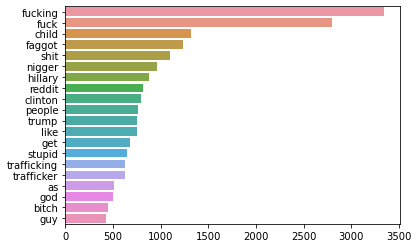

In [20]:
words_freq = labels_most_frequent_words(df, label='homophobic', column='lemmas', n_words = 20, visualise = True)
#print(words_freq)

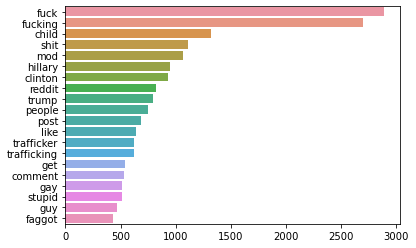

In [21]:
words_freq = labels_most_frequent_words(df, label='abuse', column='lemmas', n_words = 20, visualise = True)

In [22]:
# df with most frequent/significant/important words for each label

def get_n_most_freq_words_df(df, top_n_words, words_column):
    unique_labels = set(df['label'])
    df_labels = pd.DataFrame( columns=['label', 'n_most_freq_words', 'n_most_freq_words_frequencies'])
    for label in unique_labels:
        words_freq = labels_most_frequent_words(df, label=label, column=words_column, n_words = top_n_words, visualise = False)
        words = [word for word, freq in words_freq]
        df_labels = df_labels.append({'label': label, 'n_most_freq_words':words,'n_most_freq_words_frequencies':words_freq}, ignore_index=True)
    return df_labels

In [23]:
df_labels_freq = get_n_most_freq_words_df(df, 100, 'lemmas')

## Words that occur in each of top 10 words for label

In [155]:
#df_labels_freq_10 = get_n_most_freq_words_df(df, 10, 'lemmas')

In [156]:
#df_labels_freq_10

,label,n_most_freq_words,n_most_freq_words_frequencies
0,HSR,"[woman, sexist, mkr, people, muslim, like, isl...","[(woman, 1342), (sexist, 981), (mkr, 854), (pe..."
1,OI,"[fuck, suck, fucking, nigger, as, shit, bitch,...","[(fuck, 17897), (suck, 7835), (fucking, 5991),..."
2,HATSI,"[fuck, fucking, nigger, shit, suck, as, faggot...","[(fuck, 14063), (fucking, 8152), (nigger, 5152..."
3,VSCO,"[bitch, cunt, hoe, fuck, shit, like, fucking, ...","[(bitch, 12474), (cunt, 6028), (hoe, 4320), (f..."
4,HPH,"[jew, fucking, white, whitegenocide, like, fuc...","[(jew, 2598), (fucking, 873), (white, 779), (w..."


In [139]:
#tmp = df_labels_freq_10['n_most_freq_words'].explode()
#tmp.value_counts()

fuck       12
fucking    12
shit       10
like        9
as          9
           ..
girl        1
isi         1
prophet     1
know        1
must        1
Name: n_most_freq_words, Length: 73, dtype: int64

### TF-IDF most important words for each label

In [24]:
def get_top_n_tfidf_words_df(df, top_n_words, words_column):
    '''combines documents for each label into a single string (document) and then use this to get most important words with tf-idf
    for each document(label), return dataframe with labels and most important (tf-idf) words (in order, decreasing) for that label'''
    unique_labels = set(df['label'])
    words_by_label_string = {}
   
    for label in unique_labels:
        tmp = df[df['label'] == label][words_column]
        tmp = tmp.apply(pd.Series).stack().reset_index(drop=True)
        words_by_label_string[label] = ' '.join(list(tmp.values))
    labels, documents = list(words_by_label_string.keys()), list(words_by_label_string.values())
        
    tfIdfVectorizer=TfidfVectorizer()
    X_tf_idf_non_array = tfIdfVectorizer.fit_transform(documents)
    X_tf_idf = X_tf_idf_non_array.toarray()
    vocab = tfIdfVectorizer.vocabulary_
    reverse_vocab = {v:k for k,v in vocab.items()}
    feature_names = tfIdfVectorizer.get_feature_names()
    df_tfidf = pd.DataFrame(X_tf_idf, columns = feature_names)
    idx = X_tf_idf.argsort(axis=1) #sort and get idx for sorted values
    tfidf_max_n = idx[:,-top_n_words:] # select top n words from sorted indexes
    df_tfidf['label'] = pd.Series(labels, index=df_tfidf.index)
    df_tfidf['top_n_tfidf_words'] = [[reverse_vocab.get(item) for item in row][::-1] for row in tfidf_max_n]
    
    return df_tfidf[['label', 'top_n_tfidf_words']]


In [25]:
df_labels_tf_idf = get_top_n_tfidf_words_df(df, 100, 'lemmas')

C:\Users\hladn\Miniconda3_nov\envs\nlp_glove\lib\site-packages\pandas\core\series.py:4200: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mapped = lib.map_infer(values, f, convert=convert_dtype)
C:\Users\hladn\Miniconda3_nov\envs\nlp_glove\lib\site-packages\pandas\core\series.py:4200: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mapped = lib.map_infer(values, f, convert=convert_dtype)
C:\Users\hladn\Miniconda3_nov\envs\nlp_glove\lib\site-packages\pandas\core\series.py:4200: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mapped = lib.map_infer(values, f, convert=convert_dtype)
C:\Users\hladn\Miniconda3_nov\envs\nlp_glove\lib\sit

In [26]:
# combine tf-idf and most frequent words:
df_labels = pd.merge(df_labels_freq, df_labels_tf_idf, on='label')

In [33]:
df_labels

,label,n_most_freq_words,n_most_freq_words_frequencies,top_n_tfidf_words
0,abuse,"[fuck, fucking, child, shit, mod, hillary, cli...","[(fuck, 2889), (fucking, 2694), (child, 1317),...","[fuck, fucking, trafficker, trafficking, mod, ..."
1,harassment,"[jew, fucking, whitegenocide, white, muslim, c...","[(jew, 2581), (fucking, 712), (whitegenocide, ...","[jew, whitegenocide, fucking, whitelivesmatter..."
2,hostile,"[people, woman, black, like, white, fucking, l...","[(people, 567), (woman, 540), (black, 382), (l...","[people, woman, black, like, white, fucking, m..."
3,hateful,"[bitch, faggot, like, trumpisatraitor, nigga, ...","[(bitch, 270), (faggot, 253), (like, 246), (tr...","[trumpisatraitor, shameonicc, faggot, doctorsf..."
4,slur,"[cunt, fucking, fuck, idiot, shit, dumb, lol, ...","[(cunt, 5722), (fucking, 2148), (fuck, 2103), ...","[cunt, fucking, fuck, idiot, shit, dumb, lol, ..."
5,homophobic,"[fucking, fuck, child, faggot, shit, nigger, h...","[(fucking, 3346), (fuck, 2802), (child, 1321),...","[fucking, fuck, trafficker, trafficking, reddi..."
6,insult,"[fuck, suck, nigger, fucking, faggot, as, bitc...","[(fuck, 7976), (suck, 3746), (nigger, 2890), (...","[fuck, suck, nigger, faggot, fucking, as, bitc..."
7,severe_toxic,"[fuck, suck, as, shit, faggot, bitch, fucking,...","[(fuck, 7319), (suck, 3496), (as, 2115), (shit...","[fuck, suck, as, shit, faggot, fucksex, yourse..."
8,racist,"[islam, muslim, mohammed, religion, isi, jew, ...","[(islam, 645), (muslim, 598), (mohammed, 202),...","[islam, muslim, mohammed, fairooz, isi, prophe..."
9,sexist,"[sexist, mkr, woman, girl, kat, female, like, ...","[(sexist, 950), (mkr, 852), (woman, 686), (gir...","[mkr, sexist, kat, woman, notsexist, girl, fem..."


### tf-idf, word2vec, glove, fasttext

In [145]:
import gensim
import gensim.downloader
from gensim.models.fasttext import load_facebook_vectors

In [32]:
model_gn_glove = gensim.downloader.load('glove-wiki-gigaword-300')
model_gn_word2vec = gensim.downloader.load('word2vec-google-news-300')

In [146]:
def get_word_embeddings(labels, df, list_of_words_column, model_gn, top_n):
    word_clusters = []
    embedding_clusters = []
    model_unknown_words = []
    for label in labels:
        label_words = df[df['label']==label][list_of_words_column].iloc[0]
        embeddings = []
        words = []
        for word in label_words:
            try:
                embeddings.append(model_gn[word])
                words.append(word)
            except KeyError:
                #print(word)
                model_unknown_words.append(word)
                pass
            
        words = words[:top_n]
        embeddings = embeddings[:top_n]

        embedding_clusters.append(embeddings)
        word_clusters.append(words)
    #print(model_unknown_words)
    return word_clusters, embedding_clusters

def displayDF(word_clusters, labels):
    df = pd.DataFrame(dict(zip(labels, word_clusters)))  
    display(df)
    

def plot_similar_words_ax(ax, plot_title, labels, embedding_clusters, word_clusters, filename=None):
    # function code adapted from labs
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        ax.scatter(x, y, color=color, alpha=0.7, label=label)
        for i, word in enumerate(words):              
            ax.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
        ax.annotate(label.upper(), alpha=1.0, xy=(np.mean(x), np.mean(y)), xytext=(0, 0),
            textcoords='offset points', ha='center', va='center', size=15)
    ax.legend(loc=4)
    ax.title.set_text(plot_title)
    ax.grid(False)
    
def plotTSNE_ax(ax, title, labels, word_clusters, embedding_clusters, filename = None):
    # function code adapted from labs
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words_ax(ax, title, labels, embeddings_en_2d, word_clusters, filename)
    
def plotMDS_ax(ax, title, labels, word_clusters, embedding_clusters, filename = None):
    # function code adapted from labs
    embedding_clusters = np.array(embedding_clusters, dtype=float)
    n, m, k = embedding_clusters.shape
    model_en_2d = MDS(n_components=2, max_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words_ax(ax, title, labels, embeddings_en_2d, word_clusters, filename)
    
def plotPCA_ax(ax, title, labels, word_clusters, embedding_clusters, filename = None):
    # function code adapted from labs
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = PCA(n_components=2, random_state = 32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words_ax(ax, title, labels, embeddings_en_2d, word_clusters, filename)
    

    
def plot_similar_words(title, labels, embedding_clusters, word_clusters, filename=None):
    # function code taken from labs
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color=color, alpha=0.7, label=label)
        for i, word in enumerate(words):              
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
        plt.annotate(label.upper(), alpha=1.0, xy=(np.mean(x), np.mean(y)), xytext=(0, 0),
            textcoords='offset points', ha='center', va='center', size=15)
    plt.legend(loc=4)
    plt.title(title, fontsize=20)
    plt.grid(False)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()
    
def plotTSNE(title, labels, word_clusters, embedding_clusters, filename = None):
    # function code adapted from labs
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, labels, embeddings_en_2d, word_clusters, filename)
    
def plotMDS(title, labels, word_clusters, embedding_clusters, filename = None):
    # function code adapted from labs
    embedding_clusters = np.array(embedding_clusters, dtype=float)
    n, m, k = embedding_clusters.shape
    model_en_2d = MDS(n_components=2, max_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, labels, embeddings_en_2d, word_clusters, filename)
    
def plotPCA(title, labels, word_clusters, embedding_clusters, filename = None):
    # function code adapted from labs
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = PCA(n_components=2, random_state = 32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, labels, embeddings_en_2d, word_clusters, filename)
    

### word2vec embeddings (pretrained) visualisation

In [268]:
n_significant_words = 20
words_column = 'top_n_tfidf_words'
unique_labels = set(df['label'])
word_clusters, embedding_clusters = get_word_embeddings(unique_labels, df_labels, words_column, model_gn_word2vec, n_significant_words)


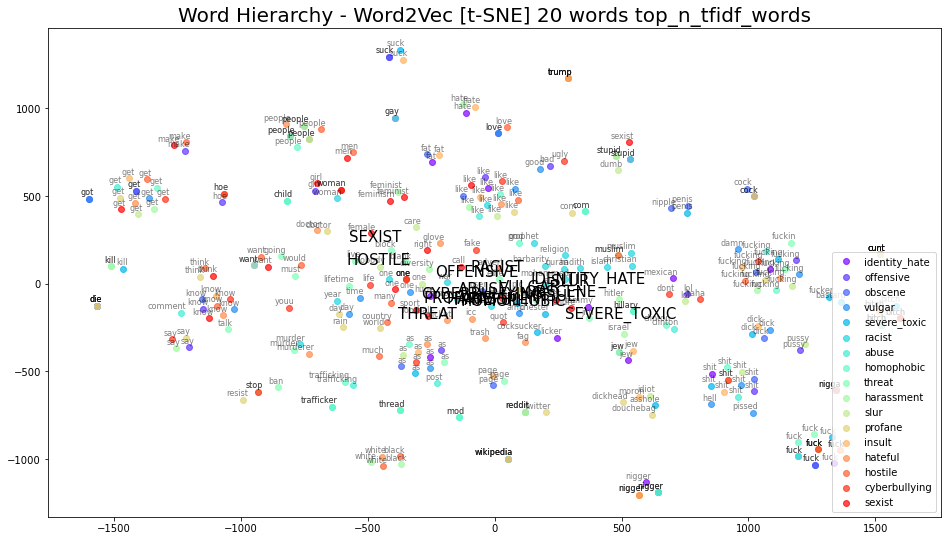

In [238]:
plotTSNE(f"Word Hierarchy - Word2Vec [t-SNE] {n_significant_words} words {words_column}", unique_labels, word_clusters, embedding_clusters, 
         f"Word Hierarchy - Word2Vec [t-SNE] {n_significant_words} words {words_column}.png")

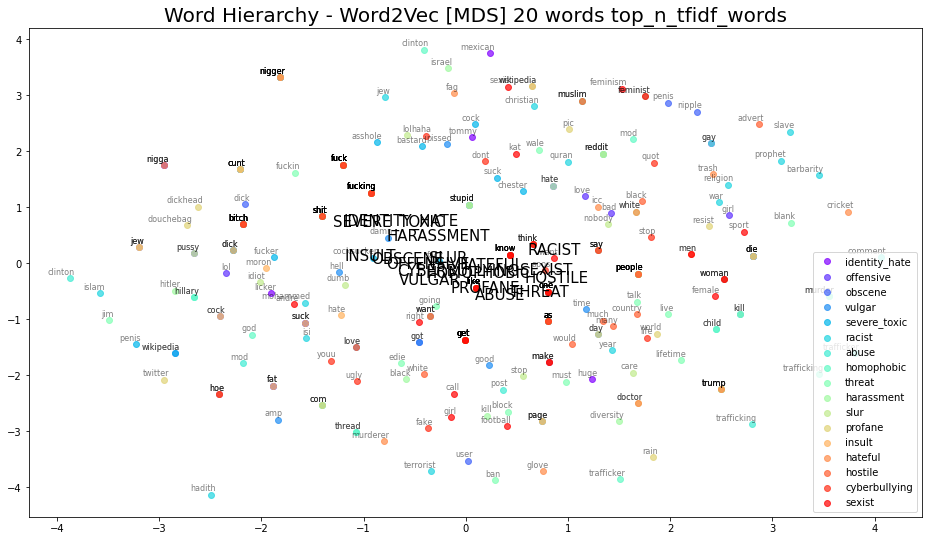

In [239]:
plotMDS(f"Word Hierarchy - Word2Vec [MDS] {n_significant_words} words {words_column}", unique_labels, word_clusters, embedding_clusters, 
        f"Word Hierarchy - Word2Vec [MDS] {n_significant_words} words {words_column}.png")

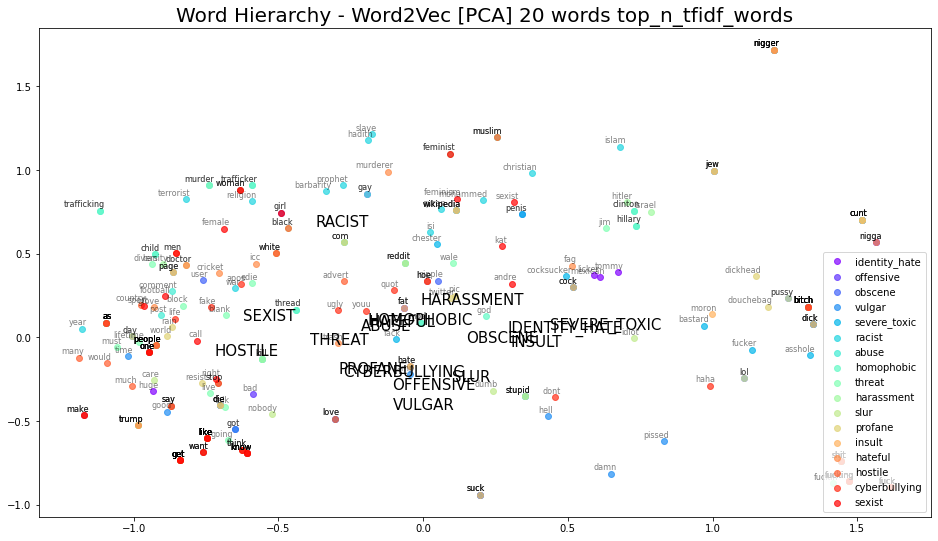

In [240]:
plotPCA(f"Word Hierarchy - Word2Vec [PCA] {n_significant_words} words {words_column}", unique_labels, word_clusters, embedding_clusters, 
        f"Word Hierarchy - Word2Vec [PCA] {n_significant_words} words {words_column}.png")

In [241]:
df_labels.sample(4)

,label,n_most_freq_words,n_most_freq_words_frequencies,top_n_tfidf_words
7,homophobic,"[fucking, fuck, child, faggot, shit, nigger, h...","[(fucking, 3346), (fuck, 2802), (child, 1321),...","[fucking, fuck, trafficker, trafficking, reddi..."
12,insult,"[fuck, suck, nigger, fucking, faggot, as, bitc...","[(fuck, 7976), (suck, 3746), (nigger, 2890), (...","[fuck, suck, nigger, faggot, fucking, as, bitc..."
5,racist,"[islam, muslim, mohammed, religion, isi, jew, ...","[(islam, 645), (muslim, 598), (mohammed, 202),...","[islam, muslim, mohammed, fairooz, isi, prophe..."
11,profane,"[fucktrump, fuck, dickhead, trump, fucking, do...","[(fucktrump, 315), (fuck, 133), (dickhead, 110...","[fucktrump, dickhead, fuck, trump, trumpisatra..."


### Glove embeddings (pretrained) visualisations

In [242]:
n_significant_words = 20 # set to whatever looks best
words_column = 'top_n_tfidf_words' # can change to 'n_most_freq_words'
unique_labels = set(df['label'])
word_clusters, embedding_clusters = get_word_embeddings(unique_labels, df_labels, words_column, model_gn_glove, n_significant_words)

In [38]:
displayDF(word_clusters, unique_labels)

,profane,offensive,threat,obscene,hostile,insult,harassment,abuse,homophobic,vulgar,identity_hate,slur,hateful,severe_toxic,cyberbullying,sexist,racist
0,fuck,bitch,die,fuck,people,fuck,jew,fuck,fucking,shit,nigger,cunt,bitch,fuck,bitch,sexist,islam
1,trump,hoe,as,suck,woman,suck,fucking,fucking,fuck,hell,jew,fucking,faggot,suck,fake,mkr,muslim
2,fucking,like,kill,shit,black,nigger,white,child,child,damn,fat,fuck,like,as,like,woman,mohammed
3,like,pussy,going,fucking,like,fucking,muslim,shit,faggot,fuck,gay,idiot,nigga,shit,get,girl,religion
4,shit,nigga,block,as,white,faggot,cunt,mod,shit,as,fuck,shit,nigger,faggot,fucking,kat,isi
5,doctor,as,fuck,nigger,fucking,as,like,hillary,nigger,bitch,die,dumb,people,bitch,shit,female,jew
6,get,got,must,bitch,love,bitch,people,clinton,hillary,like,faggot,lol,white,fucking,know,like,prophet
7,twitter,fuck,jim,faggot,men,fat,hitler,reddit,reddit,fucking,fucking,bitch,as,die,fuck,call,quran
8,resist,get,wale,cunt,country,shit,feminist,trump,clinton,get,nigga,as,get,cunt,as,men,people
9,world,shit,fucking,wikipedia,would,cunt,nigger,people,people,one,suck,pussy,trump,nigger,stop,think,like


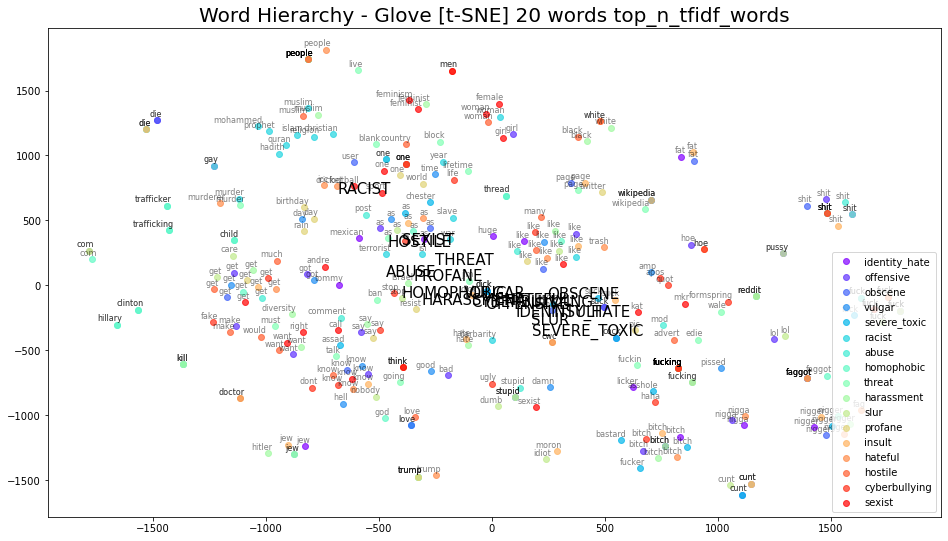

In [243]:
plotTSNE(f"Word Hierarchy - Glove [t-SNE] {n_significant_words} words {words_column}", unique_labels, word_clusters,embedding_clusters, 
         f"Word Hierarchy - Glove [t-SNE] {n_significant_words} words {words_column}.png")

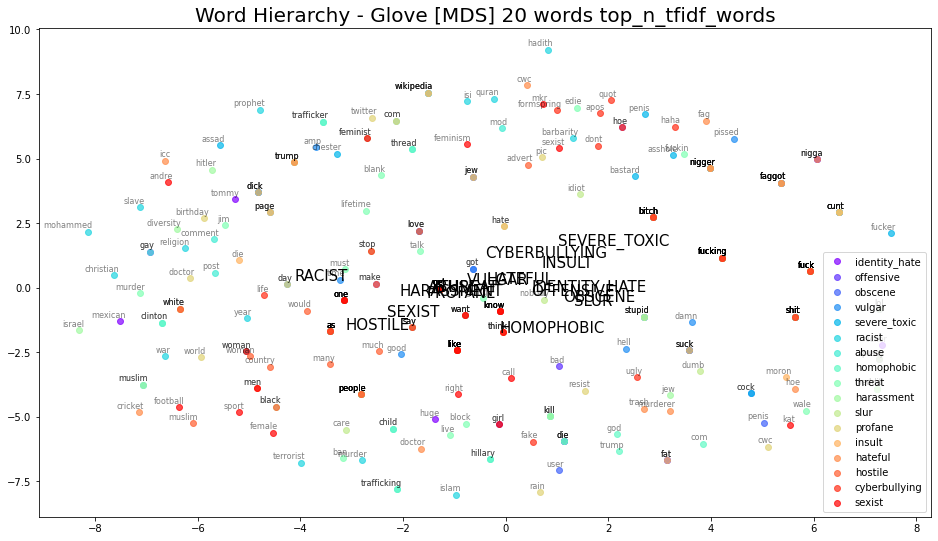

In [244]:
plotMDS(f"Word Hierarchy - Glove [MDS] {n_significant_words} words {words_column}",unique_labels, word_clusters, np.array(embedding_clusters), 
        f"Word Hierarchy - Glove [MDS] {n_significant_words} words {words_column}.png")

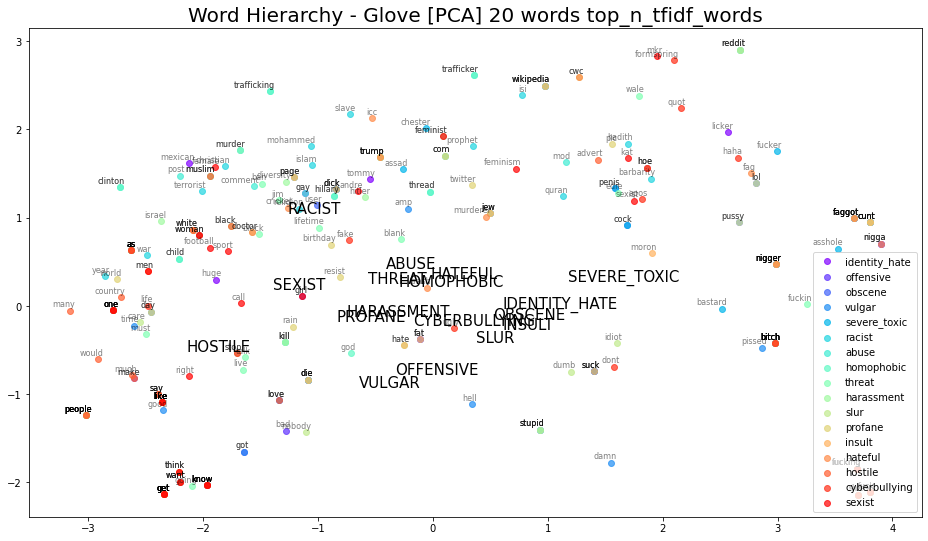

In [245]:
plotPCA(f"Word Hierarchy - Glove [PCA] {n_significant_words} words {words_column}",unique_labels, word_clusters, embedding_clusters,
        f"Word Hierarchy - Glove [PCA] {n_significant_words} words {words_column}.png")

### fasttext embedings (pretrained) visualisations

In [48]:
# Run first time only to download model (we do not recommend to try to run this as downloading the model can take multiple hours, another problem you might run in is running out of RAM)

import fasttext.util
#print('import')
#fasttext.util.download_model('en', if_exists = 'ignore')  # English
#ft = fasttext.load_model('cc.en.300.bin')

# Chaya used: https://fasttext.cc/docs/en/crawl-vectors.html
# It includes both Common Crawl and Wikipedia - file cc.en.300.bin.

model_gn = load_facebook_vectors("cc.en.300.bin")

In [52]:
model_fasttext = model_gn

In [246]:
n_significant_words=20
word_clusters, embedding_clusters = get_word_embeddings(unique_labels, df_labels, words_column, model_fasttext, n_significant_words)

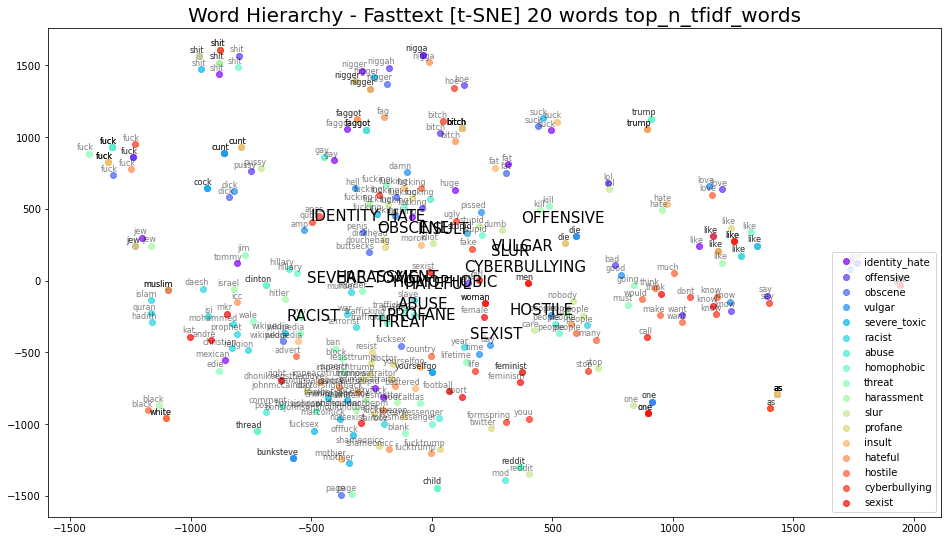

In [247]:
plotTSNE(f"Word Hierarchy - Fasttext [t-SNE] {n_significant_words} words {words_column}", unique_labels, word_clusters,embedding_clusters, 
         f"Word Hierarchy - Fasttext [t-SNE] {n_significant_words} words {words_column}.png")

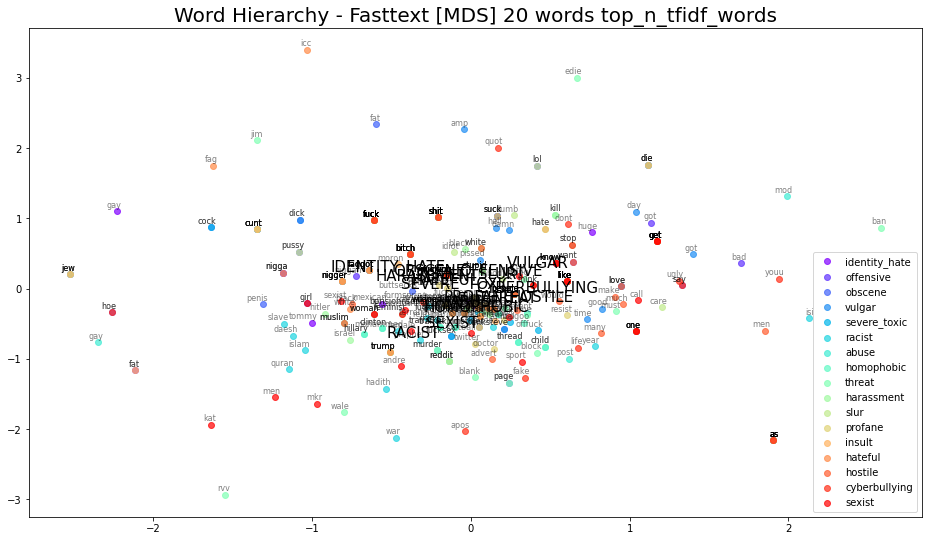

In [248]:
plotMDS(f"Word Hierarchy - Fasttext [MDS] {n_significant_words} words {words_column}",unique_labels, word_clusters, embedding_clusters,
        f"Word Hierarchy - Fasttext [MDS] {n_significant_words} words {words_column}.png")

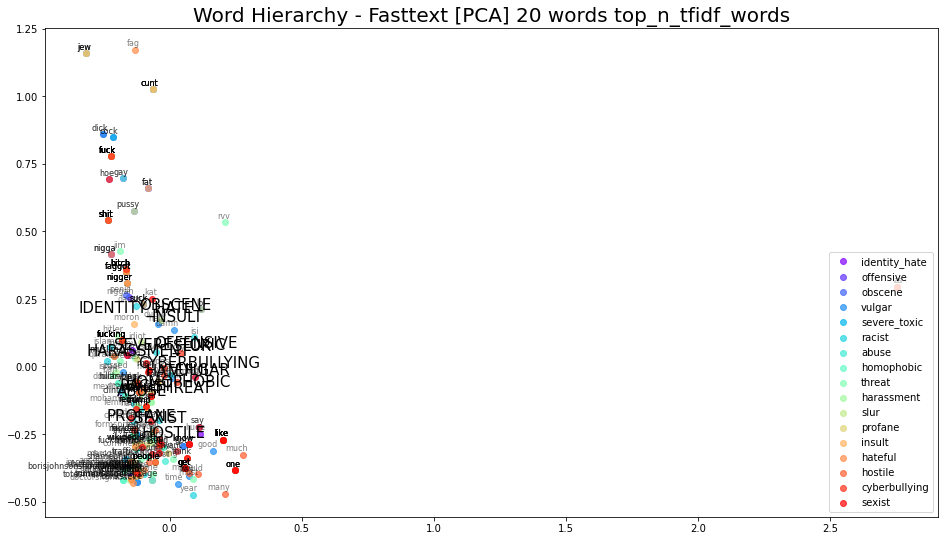

In [249]:
plotPCA(f"Word Hierarchy - Fasttext [PCA] {n_significant_words} words {words_column}",unique_labels, word_clusters, embedding_clusters,
        f"Word Hierarchy - Fasttext [PCA] {n_significant_words} words {words_column}.png")

### generating joint plots: 

normal labels

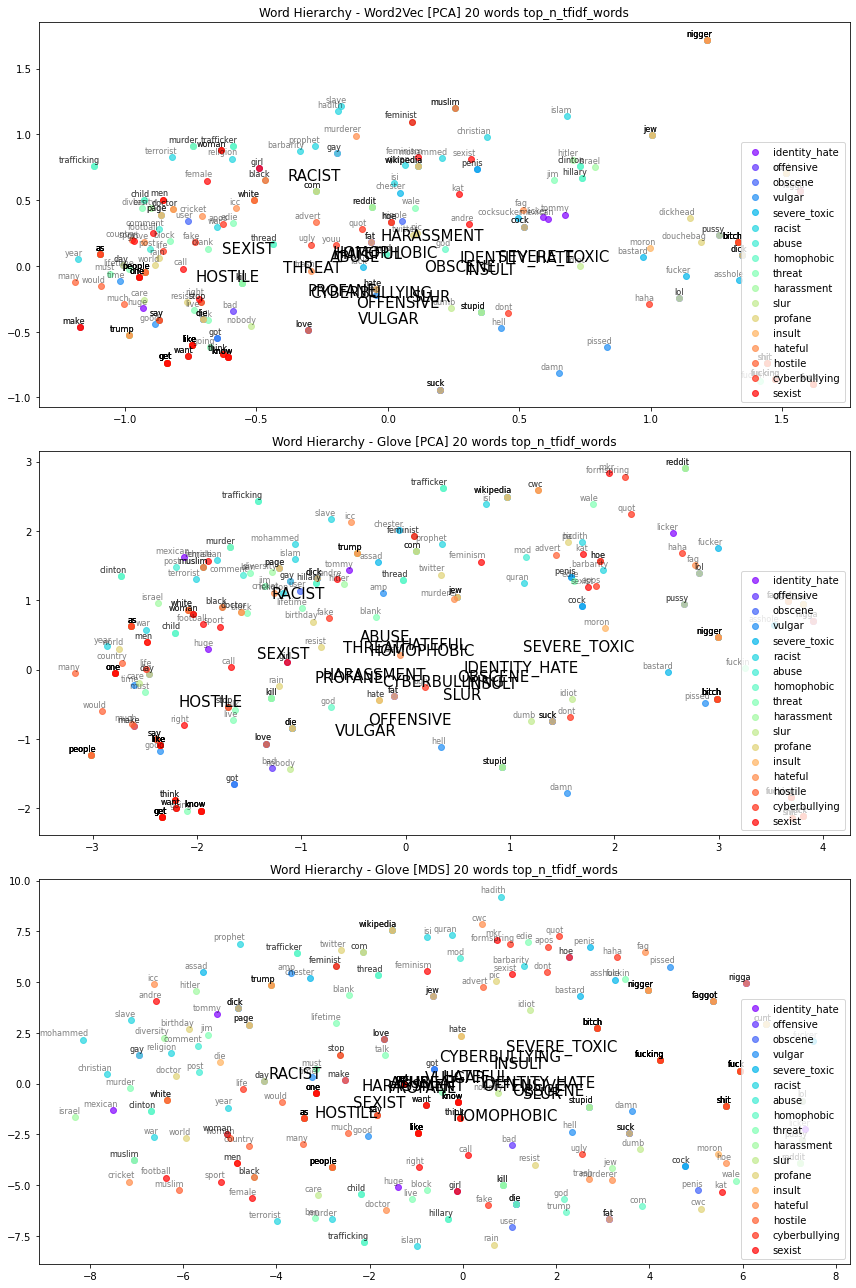

In [261]:
#displayDF(word_clusters, unique_labels)
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

n_significant_words = 20
words_column = 'top_n_tfidf_words'

unique_labels = set(df['label'])
word_clusters_w2v, embedding_clusters_w2v = get_word_embeddings(unique_labels, df_labels, words_column, model_gn_word2vec, n_significant_words)
word_clusters_gl, embedding_clusters_gl = get_word_embeddings(unique_labels, df_labels, words_column, model_gn_glove, n_significant_words)
word_clusters_ft, embedding_clusters_ft = get_word_embeddings(unique_labels, df_labels, words_column, model_fasttext, n_significant_words)

plotPCA_ax(axes[0], f"Word Hierarchy - Word2Vec [PCA] {n_significant_words} words {words_column}", unique_labels, word_clusters_w2v, embedding_clusters_w2v, 
         f"Word Hierarchy - Word2Vec [PCA] {n_significant_words} words {words_column}.png")
plotPCA_ax(axes[1], f"Word Hierarchy - Glove [PCA] {n_significant_words} words {words_column}", unique_labels, word_clusters_gl, embedding_clusters_gl, 
         f"Word Hierarchy - Glove [PCA] {n_significant_words} words {words_column}.png")
plotMDS_ax(axes[2], f"Word Hierarchy - Glove [MDS] {n_significant_words} words {words_column}", unique_labels, word_clusters_gl, embedding_clusters_gl, 
         f"Word Hierarchy - Glove [MDS] {n_significant_words} words {words_column}.png")

plt.tight_layout()
plt.savefig('report_pretrained_w2c_glove.png', format='png', dpi=150, bbox_inches='tight')
plt.show()

joint labels pretrained

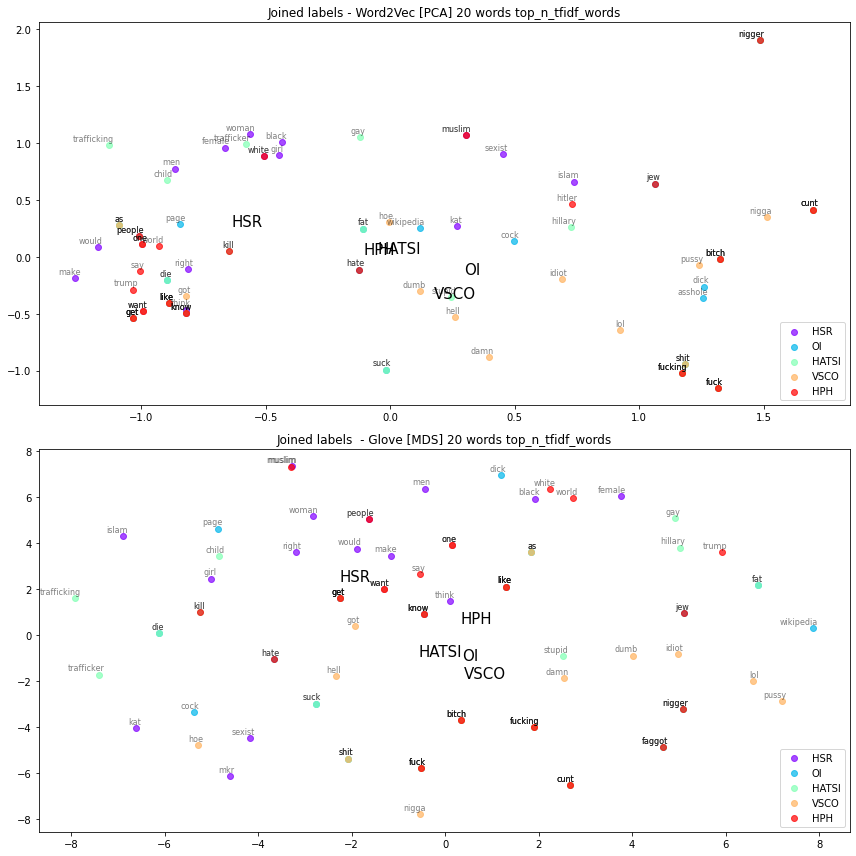

In [269]:
#displayDF(word_clusters, unique_labels)
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

n_significant_words = 20
words_column = 'top_n_tfidf_words'

unique_labels = set(df['label'])
word_clusters_w2v, embedding_clusters_w2v = get_word_embeddings(unique_labels, df_labels, words_column, model_gn_word2vec, n_significant_words)
word_clusters_gl, embedding_clusters_gl = get_word_embeddings(unique_labels, df_labels, words_column, model_gn_glove, n_significant_words)
word_clusters_ft, embedding_clusters_ft = get_word_embeddings(unique_labels, df_labels, words_column, model_fasttext, n_significant_words)

plotPCA_ax(axes[0], f"Joined labels - Word2Vec [PCA] {n_significant_words} words {words_column}", unique_labels, word_clusters_w2v, embedding_clusters_w2v, 
         f"Word Hierarchy - Word2Vec [PCA] {n_significant_words} words {words_column}.png")
plotMDS_ax(axes[1], f"Joined labels  - Glove [MDS] {n_significant_words} words {words_column}", unique_labels, word_clusters_gl, embedding_clusters_gl, 
         f"Word Hierarchy - Glove [MDS] {n_significant_words} words {words_column}.png")

plt.tight_layout()
plt.savefig('report_joined_w2c_glove.png', format='png', dpi=150, bbox_inches='tight')
plt.show()

label subset

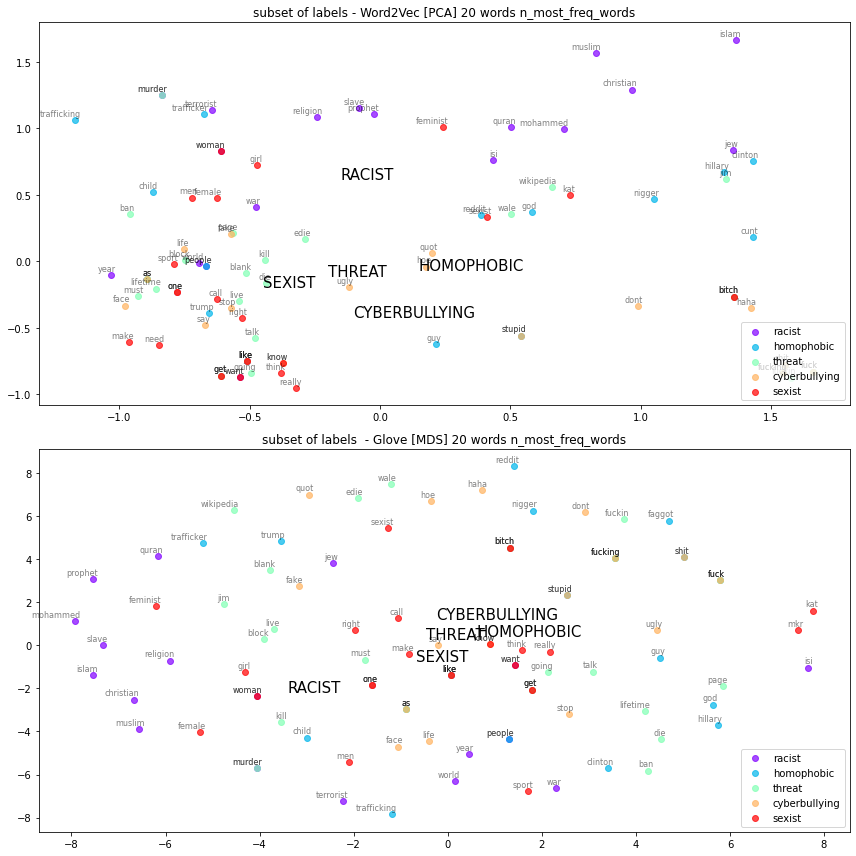

In [227]:
#displayDF(word_clusters, unique_labels)
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

n_significant_words = 20
words_column = 'n_most_freq_words'

unique_labels = set(df['label'])
word_clusters_w2v, embedding_clusters_w2v = get_word_embeddings(unique_labels, df_labels, words_column, model_gn_word2vec, n_significant_words)
word_clusters_gl, embedding_clusters_gl = get_word_embeddings(unique_labels, df_labels, words_column, model_gn_glove, n_significant_words)
word_clusters_ft, embedding_clusters_ft = get_word_embeddings(unique_labels, df_labels, words_column, model_fasttext, n_significant_words)

plotPCA_ax(axes[0], f"subset of labels - Word2Vec [PCA] {n_significant_words} words {words_column}", unique_labels, word_clusters_w2v, embedding_clusters_w2v, 
         f"Word Hierarchy - Word2Vec [PCA] {n_significant_words} words {words_column}.png")
plotMDS_ax(axes[1], f"subset of labels  - Glove [MDS] {n_significant_words} words {words_column}", unique_labels, word_clusters_gl, embedding_clusters_gl, 
         f"Word Hierarchy - Glove [MDS] {n_significant_words} words {words_column}.png")

plt.tight_layout()
plt.savefig('report_subset_w2c_glove.png', format='png', dpi=150, bbox_inches='tight')
plt.show()

## Training Glove, Word2vec, fasttext on our data

### word2vec

In [252]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
vector_len=256
model_trained_word2vec = Word2Vec(sentences=list(df['lemmas']), size=vector_len, window=5, min_count=1, workers=4)
#model_trained_word2vec.save("word2vec.model")

In [253]:
n_significant_words = 10
words_column = 'top_n_tfidf_words'
unique_labels = set(df['label'])
word_clusters, embedding_clusters = get_word_embeddings(unique_labels, df_labels, words_column, model_trained_word2vec.wv, n_significant_words)

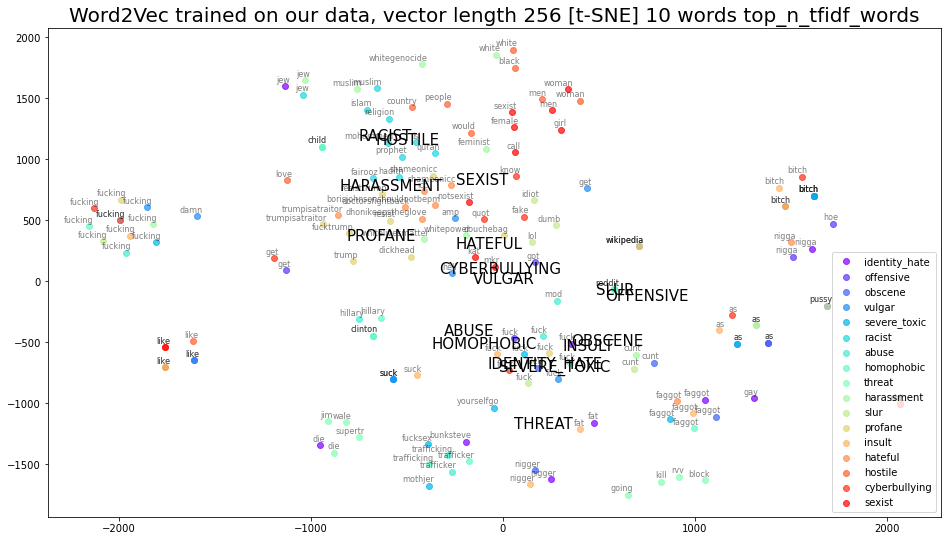

In [254]:
plotTSNE(f"Word2Vec trained on our data, vector length {vector_len} [t-SNE] {n_significant_words} words {words_column}", unique_labels, word_clusters, embedding_clusters, 
        f"Word2Vec trained on our data, vector length {vector_len} [t-SNE] {n_significant_words} words {words_column}.png")

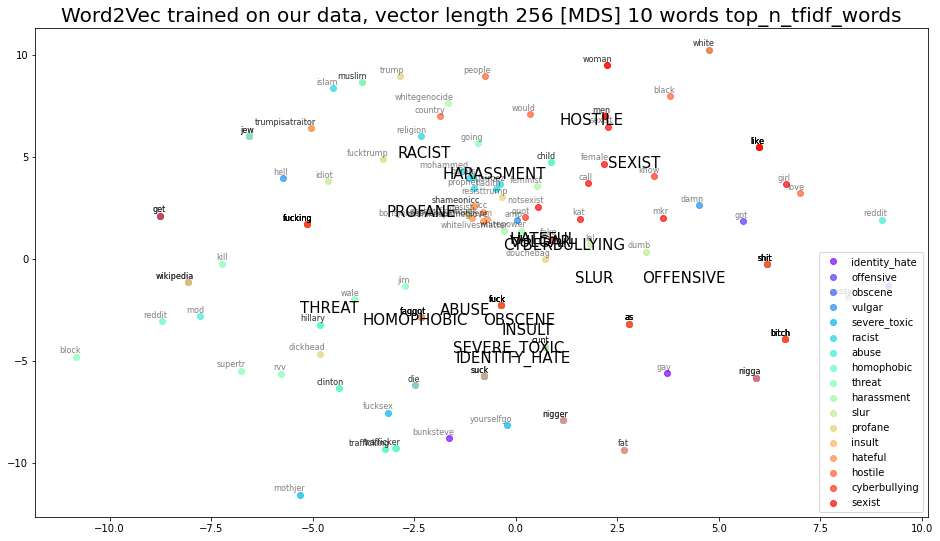

In [255]:
plotMDS(f"Word2Vec trained on our data, vector length {vector_len} [MDS] {n_significant_words} words {words_column}", unique_labels, word_clusters, embedding_clusters, 
        f"Word2Vec trained on our data, vector length {vector_len} [MDS] {n_significant_words} words {words_column}.png")

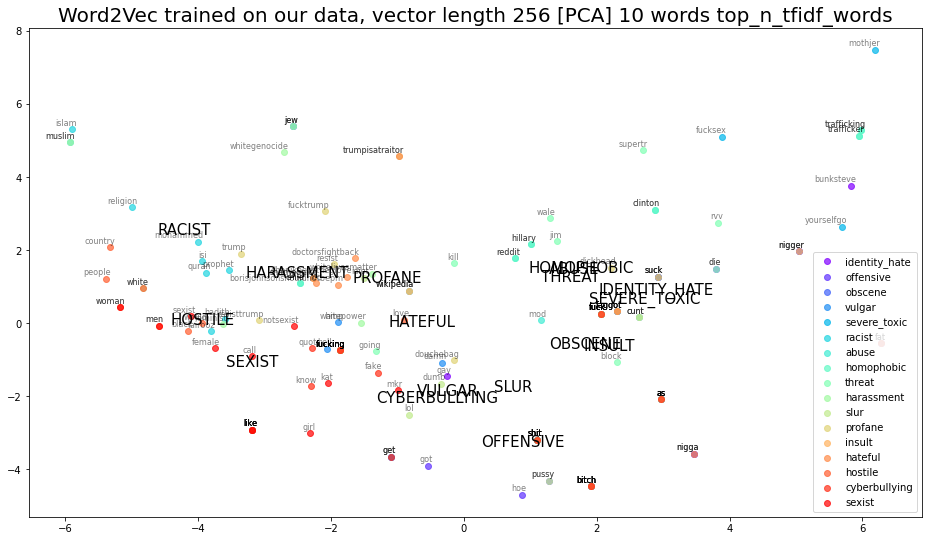

In [256]:
plotPCA(f"Word2Vec trained on our data, vector length {vector_len} [PCA] {n_significant_words} words {words_column}", unique_labels, word_clusters, embedding_clusters, 
        f"Word2Vec trained on our data, vector length {vector_len} [PCA] {n_significant_words} words {words_column}.png")

### fastText

In [257]:
from gensim.models import FastText
from gensim.test.utils import common_texts
vector_len=256
model_trained_fasttext = FastText(sentences = list(df['lemmas']), size=4, window=5, min_count=1)  # instantiate

In [258]:
n_significant_words = 20
words_column = 'top_n_tfidf_words'
unique_labels = set(df['label'])
word_clusters, embedding_clusters = get_word_embeddings(unique_labels, df_labels, words_column, model_trained_fasttext.wv, n_significant_words)

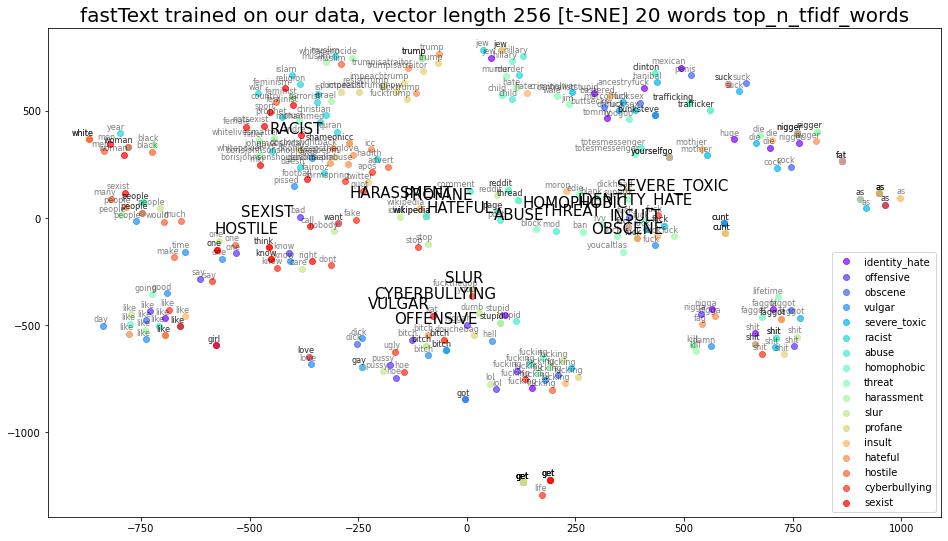

In [259]:
plotTSNE(f"fastText trained on our data, vector length {vector_len} [t-SNE] {n_significant_words} words {words_column}", unique_labels, word_clusters, embedding_clusters, 
        f"fastText trained on our data, vector length {vector_len} [t-SNE] {n_significant_words} words {words_column}.png")

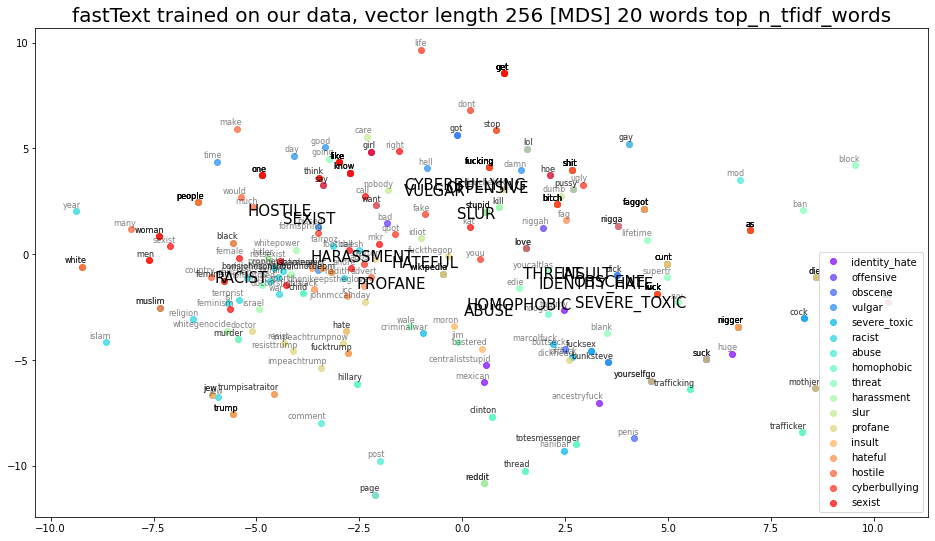

In [128]:
plotMDS(f"fastText trained on our data, vector length {vector_len} [MDS] {n_significant_words} words {words_column}", unique_labels, word_clusters, embedding_clusters, 
        f"fastText trained on our data, vector length {vector_len} [MDS] {n_significant_words} words {words_column}.png")

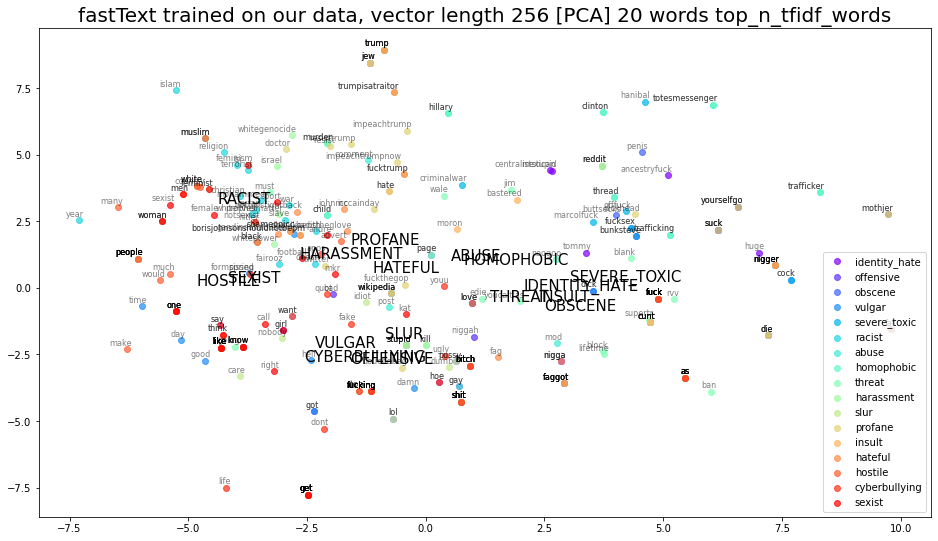

In [129]:
plotPCA(f"fastText trained on our data, vector length {vector_len} [PCA] {n_significant_words} words {words_column}", unique_labels, word_clusters, embedding_clusters, 
        f"fastText trained on our data, vector length {vector_len} [PCA] {n_significant_words} words {words_column}.png")

<ipython-input-100-e3e9b19671ab>:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings.append(model_gn[word])
<ipython-input-100-e3e9b19671ab>:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings.append(model_gn[word])
<ipython-input-100-e3e9b19671ab>:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings.append(model_gn[word])


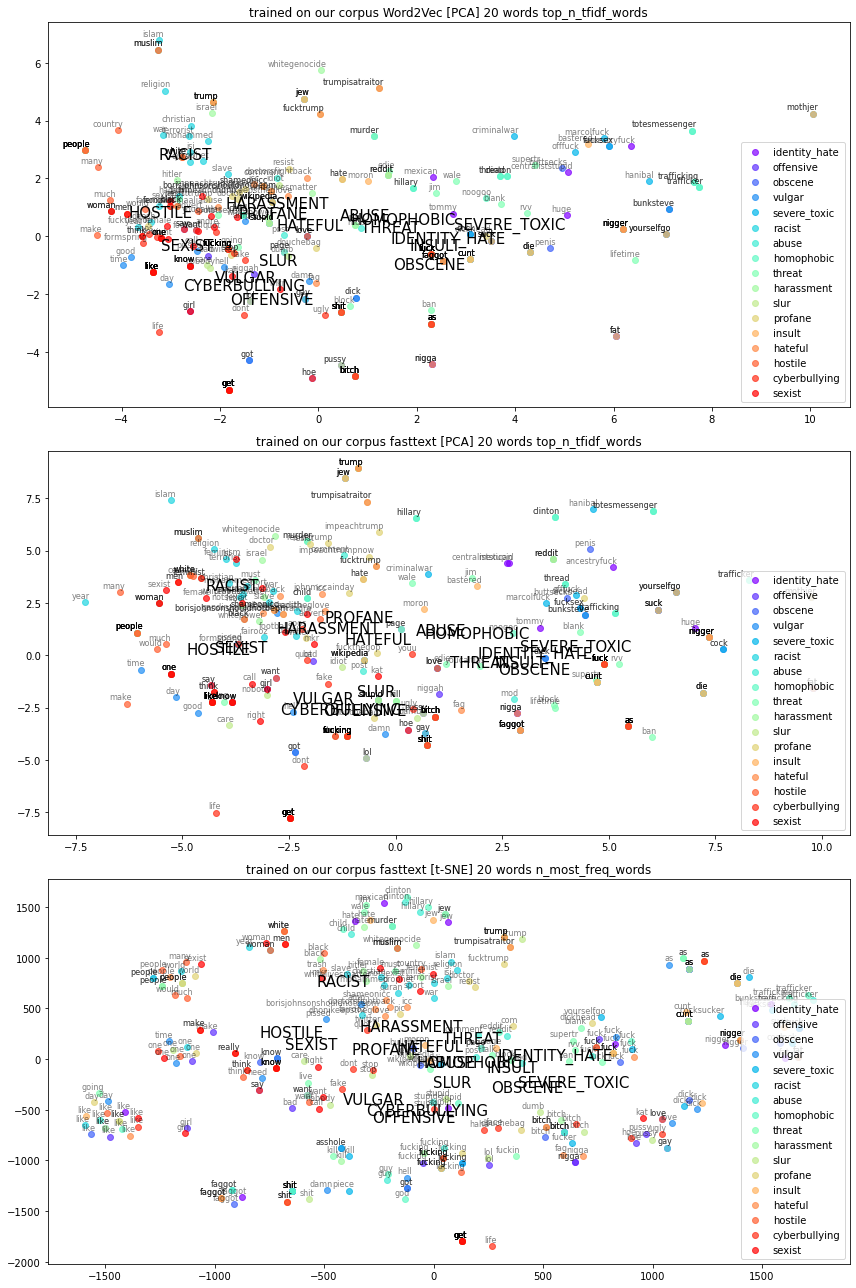

In [130]:
fig, axes = plt.subplots(3, 1, figsize=(12, 18))


n_significant_words = 20
words_column = 'top_n_tfidf_words'
unique_labels = set(df['label'])
word_clusters_w2v_train, embedding_clusters_w2v_train = get_word_embeddings(unique_labels, df_labels, words_column, model_trained_word2vec, n_significant_words)

plotPCA_ax(axes[0], f"trained on our corpus Word2Vec [PCA] {n_significant_words} words {words_column}", unique_labels, word_clusters_w2v_train, embedding_clusters_w2v_train, 
         f".png")

n_significant_words = 20
words_column = 'top_n_tfidf_words'
unique_labels = set(df['label'])
word_clusters_ft_train, embedding_clusters_ft_train = get_word_embeddings(unique_labels, df_labels, words_column, model_trained_fasttext, n_significant_words)

plotPCA_ax(axes[1], f"trained on our corpus fasttext [PCA] {n_significant_words} words {words_column}", unique_labels, word_clusters_ft_train, embedding_clusters_ft_train, 
         f"Word Hierarchy .png")

n_significant_words = 20
words_column = 'n_most_freq_words'
unique_labels = set(df['label'])
word_clusters_ft_train, embedding_clusters_ft_train = get_word_embeddings(unique_labels, df_labels, words_column, model_trained_fasttext, n_significant_words)

plotTSNE_ax(axes[2], f"trained on our corpus fasttext [t-SNE] {n_significant_words} words {words_column}", unique_labels, word_clusters_ft_train, embedding_clusters_ft_train, 
         f"Word Hierarchy .png")

plt.tight_layout()
plt.savefig('report_ourtrained_w2c_fasttext.png', format='png', dpi=150, bbox_inches='tight')
plt.show()

# Topic modelling

In [34]:
from gensim import corpora
import pickle

dictionary = corpora.Dictionary(list(df['lemmas']))
corpus = [dictionary.doc2bow(text) for text in list(df['lemmas'])]

pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [35]:
import gensim
NUM_TOPICS = 6
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=10)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.197*"cunt" + 0.046*"kill" + 0.025*"wikipedia" + 0.017*"block"')
(1, '0.284*"fuck" + 0.085*"suck" + 0.069*"shit" + 0.046*"faggot"')
(2, '0.045*"nigger" + 0.027*"hate" + 0.016*"fucksex" + 0.015*"muslim"')
(3, '0.115*"bitch" + 0.095*"as" + 0.053*"die" + 0.028*"pussy"')
(4, '0.021*"hell" + 0.020*"like" + 0.016*"get" + 0.012*"hoe"')
(5, '0.066*"fucking" + 0.023*"idiot" + 0.020*"stupid" + 0.015*"shit"')


### LDA topic visualisation

In [30]:
import gensim
import pickle
import pyLDAvis.gensim
'''
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
ldamodel = gensim.models.ldamodel.LdaModel.load('model5.gensim')
'''

lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [31]:
topics = ldamodel.show_topics(formatted=False)
topics

[(0,
  [('fuck', 0.12219111),
   ('cunt', 0.07488276),
   ('as', 0.059320416),
   ('shit', 0.03861848),
   ('bitch', 0.037242375),
   ('suck', 0.036768824),
   ('die', 0.033076286),
   ('fucking', 0.024124965),
   ('pussy', 0.017757038),
   ('nigger', 0.014764246)]),
 (1,
  [('fucking', 0.07634763),
   ('idiot', 0.045464687),
   ('lol', 0.018086357),
   ('bastard', 0.01721802),
   ('trump', 0.016361807),
   ('post', 0.013396322),
   ('retarded', 0.011584256),
   ('old', 0.011283054),
   ('moron', 0.011100386),
   ('pro', 0.0101102255)]),
 (2,
  [('hate', 0.026145017),
   ('muslim', 0.014808512),
   ('piece', 0.014439749),
   ('islam', 0.013902033),
   ('people', 0.012931054),
   ('lmao', 0.0093201455),
   ('thanks', 0.009208904),
   ('racist', 0.008773702),
   ('cocksucking', 0.0077340915),
   ('yet', 0.007097312)]),
 (3,
  [('fucksex', 0.04023467),
   ('offfuck', 0.022764526),
   ('child', 0.020790681),
   ('bot', 0.02052382),
   ('respect', 0.019529974),
   ('reddit', 0.01926169),
  

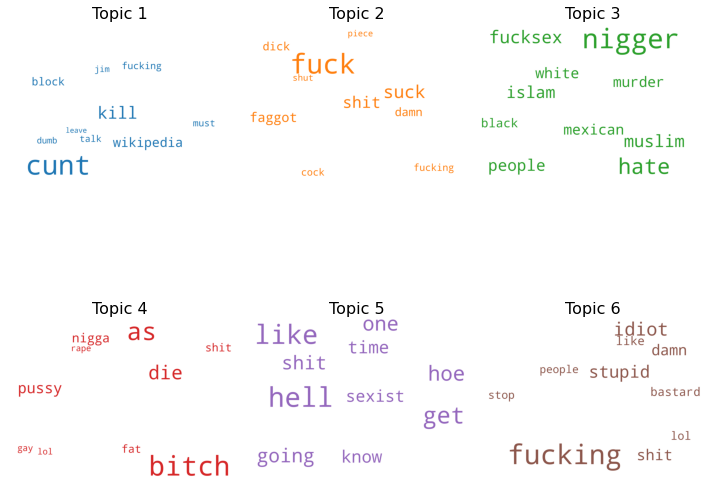

In [36]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('topic_modelling_words.png')
plt.show()